In [1]:
# from google.colab import drive
import os

# # 1. Mount your Google Drive
# print("Mounting Google Drive...")
# drive.mount('/content/drive')
# print("Drive mounted successfully.")

# 2. Install required libraries
print("Installing dependencies...")
!pip install -q timm pandas scikit-learn
print("✅ All dependencies installed.")

Installing dependencies...
✅ All dependencies installed.


In [2]:
import os

# Define the path to your LOCAL dataset folder.
# This is the only path you need to set.


# Example for macOS or Linux:
LOCAL_DATASET_PATH = '/home/akmal-ali/3rd_year/cw/dsi/project/Dataset'


# Verify the path exists
if not os.path.exists(LOCAL_DATASET_PATH):
    raise FileNotFoundError(f"The specified dataset path was not found: {LOCAL_DATASET_PATH}")
else:
    print(f"✅ Using local dataset from: {LOCAL_DATASET_PATH}")

✅ Using local dataset from: /home/akmal-ali/3rd_year/cw/dsi/project/Dataset


In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

print("Defining custom PyTorch Dataset...")

class HTPMultiLabelDataset(Dataset):
    """
    Custom Dataset for loading the HTP multi-label data.
    This version automatically drops specified useless labels.
    """
    def __init__(self, csv_path, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.df = pd.read_csv(csv_path)
        self.df.rename(columns={self.df.columns[0]: 'filename'}, inplace=True)

        # --- SOLUTION 1: Drop useless columns ---
        labels_to_drop = ['tree']
        self.df = self.df.drop(columns=labels_to_drop, errors='ignore')

        self.label_columns = self.df.columns.tolist()[1:]
        self.num_labels = len(self.label_columns)
        print(f"  Loaded {csv_path}. Found {len(self.df)} images and {self.num_labels} labels.")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['filename']
        img_path = os.path.join(self.img_dir, img_name)

        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            image = Image.new("RGB", (224, 224), (255, 255, 255))

        if self.transform:
            image = self.transform(image)

        labels = row[self.label_columns].values.astype('float')
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        return image, labels_tensor

print("✅ Custom HTPMultiLabelDataset defined (now drops 'tree' label).")

Defining custom PyTorch Dataset...
✅ Custom HTPMultiLabelDataset defined (now drops 'tree' label).


In [4]:
from torch.utils.data import DataLoader
import numpy as np

print("Defining image transforms and DataLoaders...")

# --- 1. Define Image Transforms ---
IMAGE_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# --- 2. Create Dataset Instances (using LOCAL_DATASET_PATH) ---
TRAIN_CSV = os.path.join(LOCAL_DATASET_PATH, 'train', '_classes.csv')
TRAIN_DIR = os.path.join(LOCAL_DATASET_PATH, 'train')
VALID_CSV = os.path.join(LOCAL_DATASET_PATH, 'valid', '_classes.csv')
VALID_DIR = os.path.join(LOCAL_DATASET_PATH, 'valid')
TEST_CSV = os.path.join(LOCAL_DATASET_PATH, 'test', '_classes.csv')
TEST_DIR = os.path.join(LOCAL_DATASET_PATH, 'test')

# Instantiate the Datasets
train_dataset = HTPMultiLabelDataset(TRAIN_CSV, TRAIN_DIR, transform=train_transform)
valid_dataset = HTPMultiLabelDataset(VALID_CSV, VALID_DIR, transform=val_transform)
test_dataset = HTPMultiLabelDataset(TEST_CSV, TEST_DIR, transform=val_transform)

# --- 3. Get Label Information ---
NUM_LABELS = train_dataset.num_labels
LABEL_NAMES = train_dataset.label_columns
print(f"Model will be trained to predict {NUM_LABELS} labels.")

# --- 4. SOLUTION 2: Calculate positive weights for class imbalance ---
print("Calculating weights for class imbalance...")
all_labels = train_dataset.df[LABEL_NAMES].values
pos_counts = np.sum(all_labels, axis=0)
neg_counts = len(all_labels) - pos_counts
pos_weight_tensor = torch.tensor(neg_counts / (pos_counts + 1e-6), dtype=torch.float32)
print(f"Calculated weights for {len(pos_weight_tensor)} labels.")

# --- 5. Create DataLoaders ---
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("✅ DataLoaders are ready (with pos_weight calculated).")

Defining image transforms and DataLoaders...
  Loaded /home/akmal-ali/3rd_year/cw/dsi/project/Dataset/train/_classes.csv. Found 905 images and 25 labels.
  Loaded /home/akmal-ali/3rd_year/cw/dsi/project/Dataset/valid/_classes.csv. Found 65 images and 25 labels.
  Loaded /home/akmal-ali/3rd_year/cw/dsi/project/Dataset/test/_classes.csv. Found 40 images and 25 labels.
Model will be trained to predict 25 labels.
Calculating weights for class imbalance...
Calculated weights for 25 labels.
✅ DataLoaders are ready (with pos_weight calculated).


In [5]:
import timm
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
import numpy as np
import time

print("Defining model and training functions...")

# --- 1. Define the Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = timm.create_model("efficientnet_b0", pretrained=True)
for param in model.parameters():
    param.requires_grad = False

in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, NUM_LABELS)
model = model.to(device)
print(f"Model 'efficientnet_b0' loaded for {NUM_LABELS} outputs.")

# --- 2. Define Loss and Optimizer (MODIFIED) ---
# Move our weight tensor to the GPU
pos_weight_tensor = pos_weight_tensor.to(device)
# Pass the weights to the loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
print("Loss function is now weighted (using pos_weight).")

optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)

# --- 3. Training Function ---
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

# --- 4. Evaluation Function ---
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    avg_loss = running_loss / len(loader)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    f1 = f1_score(all_labels, all_preds, average='micro')
    return avg_loss, f1

print("✅ Training and evaluation functions defined.")

/home/akmal-ali/miniconda3/envs/smai/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/akmal-ali/miniconda3/envs/smai/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened

Defining model and training functions...
Using device: cuda
Model 'efficientnet_b0' loaded for 25 outputs.
Loss function is now weighted (using pos_weight).
✅ Training and evaluation functions defined.


In [6]:
import time

NUM_EPOCHS = 30
best_val_f1 = 0.0
MODEL_SAVE_PATH = "best_htp_classifier.pth"

print(f"--- 🚀 Starting Training for {NUM_EPOCHS} Epochs 🚀 ---")

for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_f1 = evaluate(model, valid_loader, criterion, device)
    end_time = time.time()

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Time: {end_time - start_time:.2f}s | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val F1-Score: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"  ✨ New best model saved with F1-Score: {best_val_f1:.4f}")

print(f"--- ✅ Training Complete ---")
print(f"Best model saved to {MODEL_SAVE_PATH} with F1-Score: {best_val_f1:.4f}")

--- 🚀 Starting Training for 30 Epochs 🚀 ---


Epoch 1/30 | Time: 4.53s | Train Loss: 1.3298 | Val Loss: 1.5174 | Val F1-Score: 0.2686
  ✨ New best model saved with F1-Score: 0.2686
Epoch 2/30 | Time: 3.25s | Train Loss: 1.0648 | Val Loss: 1.4618 | Val F1-Score: 0.2551
Epoch 3/30 | Time: 3.38s | Train Loss: 0.9286 | Val Loss: 1.4837 | Val F1-Score: 0.2788
  ✨ New best model saved with F1-Score: 0.2788
Epoch 4/30 | Time: 3.57s | Train Loss: 0.8430 | Val Loss: 1.4893 | Val F1-Score: 0.2902
  ✨ New best model saved with F1-Score: 0.2902
Epoch 5/30 | Time: 3.39s | Train Loss: 0.8042 | Val Loss: 1.4596 | Val F1-Score: 0.2877
Epoch 6/30 | Time: 3.28s | Train Loss: 0.7638 | Val Loss: 1.5379 | Val F1-Score: 0.3049
  ✨ New best model saved with F1-Score: 0.3049
Epoch 7/30 | Time: 3.61s | Train Loss: 0.7059 | Val Loss: 1.5356 | Val F1-Score: 0.3005
Epoch 8/30 | Time: 3.41s | Train Loss: 0.6719 | Val Loss: 1.5178 | Val F1-Score: 0.3254
  ✨ New best model saved with F1-Score: 0.3254
Epoch 9/30 | Time: 3.56s | Train Loss: 0.6493 | Val Loss: 1.6

In [7]:
import torch
import timm
import torch.nn as nn

print("--- 🧪 Evaluating Model on the (Unseen) Test Set ---")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_SAVE_PATH = "best_htp_classifier.pth"

# Re-define Model Structure
model_for_testing = timm.create_model("efficientnet_b0", pretrained=False)
model_for_testing.classifier = nn.Linear(model_for_testing.classifier.in_features, NUM_LABELS)

# Load Saved Weights
model_for_testing.load_state_dict(torch.load(MODEL_SAVE_PATH))
model_for_testing = model_for_testing.to(device)
model_for_testing.eval()
print("Best model loaded for testing.")

# Define the Criterion
pos_weight_tensor = pos_weight_tensor.to(device)
criterion_for_test = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

print(f"Running evaluation on {len(test_dataset)} test images...")

# Run Evaluation
test_loss, test_f1 = evaluate(model_for_testing, test_loader, criterion_for_test, device)

print("\n--- 🏁 FINAL TEST REPORT 🏁 ---")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test F1-Score (Micro): {test_f1:.4f}")

--- 🧪 Evaluating Model on the (Unseen) Test Set ---
Best model loaded for testing.
Running evaluation on 40 test images...

--- 🏁 FINAL TEST REPORT 🏁 ---
  Test Loss: 3.0069
  Test F1-Score (Micro): 0.3729


In [8]:
!pip install -q -U transformers accelerate bitsandbytes
# print("✅ LLM libraries installed.")

In [ ]:
import torch
from PIL import Image
import os
import timm
import torch.nn as nn
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

print("--- 🔬 Loading the 'Seer' (EfficientNet) and the 'Interpreter' (Mistral LLM) ---")

# --- 1. DEFINE YOUR RAG KNOWLEDGE BASE ---
# This is the context you provided.
RAG_CONTEXT = """
- ANIMAL PEEKING FROM HOLE IN TREE • Feeling that segment of personality is pathoformically free from control and presumably has destructive potentialities; obsessive guilt. • Children often identify with an animal, thus depicting regressive yearnings for withdrawn, warm, protecting uterine existence.
- APPLE TREE • Frequently drawn by dependent children. • Pregnant women or those desiring children often draw apple trees.
- APPLES, FALLING OR FALLEN • Indicates child's feeling of rejection.
- BARK Depicted by vine-like vertical lines well separated • Suggests schizoid characteristics.
- BARK Easily drawn • Well-balanced interaction.
- BARK Inconsistently or heavily drawn • Anxiety.
- BARK Meticulously drawn • Compulsiveness with overconcern about relationships with environment.
- BRANCHES • Degree of flexibility of branches, number, size, and extent of interrelationship indicate view of adaptability and availability for deriving satisfactions in environment.
- BRANCHES Absolute symmetry of • Implies feelings of ambivalence; inability to grant dominance to emotional or intellectual course of action.
- BRANCHES Broken, bent, or dead • Significant psychic or physical trauma. • Castration feelings: psychosexual or psychosocial.
- BRANCHES Indicated by shaded implication • When easily and quickly drawn, indicative of tactful but possibly superficial interaction.
- BRANCHES Indicated by unshaded implication • Oppositional tendencies.
- BRANCHES Intended to be two dimensional but not "closed" at distal end • Little control over expression of drives.
- BRANCHES New growth protruding from barren trunk • Reversal of crippling belief that seeking satisfaction from environment was fruitless. • Probably sexual rejuvenation, if history of impotence exists.
- BRANCHES One-dimensional, not forming a system and inadequately joined to a one-dimensional trunk • Organicity. • Impotence feelings, futility, lack of ego strength with poor integration of satisfaction-seeking resources.
- BRANCHES One- or two-dimensional, turning inward • Strong intratensive ruminative tendencies.
- BRANCHES Overemphasis to left • Personality imbalance due to tendency to seek strenuously for immediate, frank emotional satisfaction: extratensivity.
- BRANCHES Overemphasis to right • Personality imbalance produced by strong tendency to avoid or delay emotional satisfaction, or seek satisfaction through intellectual effort.
- BRANCHES Phallic-like • Sexual preoccupations. • Strivings for virility.
- BRANCHES Spike-like • Subconscious castration fear. • Masochistic tendencies if point is at trunk end of branch.
- BRANCHES Two-dimensional, drawn like clubs or fingers with little organization • Strong hostility and aggression. • If not overtly aggressive, hostility is repressed with considerable inner tension created.
- BRANCHES Two-dimensional, partially drawn with relatively refined branch system and foliage by implication • Implies well-developed ability to deal successfully with people, as in social work.
- BRANCHES "Wrapped" at ends in cloud-like balls • Inhibitions prevent outward discharge of aggression.
- BRANCH STRUCTURE Abruptly flattened at top • Attempt to reject or deny painful fantasy life.
- BRANCH STRUCTURE Overly large in relation to trunk • Feeling of basic inadequacy with concomitant overstriving to secure satisfaction from environment.
- BRANCH STRUCTURE Tall and narrow • Tendency to fear seeking satisfaction from and in environment.
- DETAILS, ESSENTIAL • Trunk and one branch may be regarded as normal when the drawing is identified as a stump.
- GROUND, TRANSPARENCIY OF, ROOTS SHOWN BELOW SURFACE • Pathoformic reality flaw. • Suggestive of organicity.
- GROUNDLINE, ARC-LIKE HILL • Tree upon crest of arc-like hill frequently represents oral-erotic fixation with need for maternal protection. • When Tree is small, maternal dependence with feelings of isolation and helplessness indicated.
- LEAVES Fallen or falling • Feels losing ability to hide thoughts and feelings. • Feels losing ability for more controlled and delicate adjustments in and to environment.
- LEAVES Many presented in detail • Obsessive-compulsive characteristics.
- LEAVES Two-dimensional, too large for branches • Wishes to mask basic feelings of inadequacy with cloak of superficial adjustment. • Overcompensatory attempt to take flight into reality.
- PERSPECTIVE Below subject • Defeatist attitude. • Tendency toward concretivity. • Rejection of person represented by Tree.
- PERSPECTIVE Partly up a hill • Feelings of striving. • Need for shelter and security.
- PERSPECTIVE Top of hill, by itself • Sometimes indicates feeling of superiority. • Sometimes represents feeling of isolation, concomitant with struggle for autonomy.
- ROOTS Dead • Intrapersonal imbalance or dissolution with suggested pathoformic loss of drive and grasp of reality. • Obsessive-depressive feelings associated with early life.
- ROOTS Entering ground, overemphasis upon • Great need to maintain grasp of reality. • Insecurity.
- ROOTS Talon-like, not penetrating ground surface • Poor reality contact. • Paranoid aggressive attitudes suggested.
- ROOTS Thin-lined, making tenuous contact with ground • Poor reality contact.
- ROOTS Transparent from underground • Impairment of reality awareness. • Organicity, particularly in children.
- SCARS • Psychic and/or physical experience regarded traumatically.
- SHADOW • Anxiety-binding factor within conscious level of personality. • Unsatisfying relationship of psychological past with psychological present.
- SUN Large • Acute awareness of relationship to authority figure.
- SUN Location of • Relationship of Tree to source of warmth and/or power. • Frequently symbolizes relationship felt between the subject and dominant environmental figure.
- SUN Setting • Feelings of depression.
- TREE Drawn as two one-dimensional trees • Strongly suggests pathologic dichotomy of affect and intellect. • Organicity suspected.
- TREE "Keyhole" • Strong hostile impulses. • Somewhat rigid personality, with much potential for explosive behavior.
- TREE Large but contained within page • Acutely aware of self in environment. • Likely to attempt to secure satisfaction in activity rather than fantasy.
- TREE Leaning to left • Imbalance of personality because of desire to secure frank, immediate, emotional satisfaction in behaving impulsively. • Fixation on past and/or fear of future.
- TREE Leaning to right • Imbalance of personality due to fear of frank, emotional expression with concomitant overemphasis upon intellectual satisfactions. • Fixation on future and/or desire to forget unhappy past.
- TREE "Phallic" • Common for children under 8 years. • Suggests psychosexual immaturity and/or phallic preoccupations.
- TREE Small • Feels inferior and inadequate. • Desire to withdraw.
- TRUNK Broad at base with rapid diminishing of breadth • Early environment lacking in warmth and healthful stimulation with resultant cramping effect on personality maturation.
- TRUNK Broken and tip of tree touching ground • Symbolically expresses feeling of having been overwhelmed by internal or external forces beyond control.
- TRUNK Dead • Feels crippling loss of ego control.
- TRUNK Faint lines • Feeling of lack of ego strength, indecision and inadequacy, accompanied by anxiety.
- TRUNK Large, with small branch structure • Precarious personality balance because of frustration engendered by inability to satisfy strong basic needs. • Emotional immaturity or egocentricity.
- TRUNK Leaning to left and then to right • Tendency at early age to regress and behave impulsively and at later age to overcompensate by strong controls and fixation on future.
- TRUNK Narrower at base than at higher points • Striving beyond the subject's strength with concomitant implications of possible collapse of ego control.
- TRUNK One-dimensional, with one-dimensional branches that do not form a system • Organic state suspected. • Feelings of impotence, futility, and lack of ego strength.
- TRUNK Overly large • Feelings of environmental constriction with tendency to react aggressively in reality or fantasy.
- TRUNK Reinforcement of peripheral lines • Need to maintain control or personality intactness. • Employs compensatory defenses to cloak and combat fear of personality diffusion.
- TRUNK Tiny • Feelings of basic inadequacy and ineptness.
- TRUNK Truncated with tiny branches growing from stump • Core of self felt to be damaged. • Stunted growth with renewed efforts or hope for regrowth.
- TRGUNK Two-dimensional, with one-dimensional branches • Good early development but later interference by serious traumatic events.
- TRUNK Very slender, with large branch structures • Precarious personality balance because of over-striving for satisfaction.
- WIND Blowing from ground level to tree-top • Compulsive need to escape reality and enter fantasy.
- WIND Blowing from subject • Desire to deny feelings of pressure. • Desire to aggress against sources of frustration.
- WIND Blowing from top to bottom • Compulsive need to escape fantasy and return to reality.
- WIND Blowing from Tree toward subject • Narcissistic tendency; for example, wishes or feels control over person the Tree represents.
- WIND Blowing in all directions simultaneously • Suggestive of acute reality testing failure.
"""
print("RAG context defined.")

# --- 2. SETUP THE "SEER" (Your EfficientNet Model) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# This list must be accurate, based on your CSV after dropping 'tree'
# It should be 26 items.
LABEL_NAMES = [
    'Bark with Heavy Shading', 'Birds in Tree', 'Branches Extending Upward',
    'Branches Touching Ground', 'Cloud-Shaped Branches', 'Crooked Trunk',
    'Cut or Detached Branches', 'Dead Tree', 'Downward Drooping Branches',
    'Extra Detail on Leaves', 'Fantasy-Like Tree', 'Fruit on Tree',
    'Hallow or Scarred Trunk', 'Large Tree', 'Nest in Branches', 'Palm Tree',
    'Pine Tree', 'Pointy Leaves', 'Roots', 'Small Tree', 'Thick Tree',
    'Thin Tree', 'Tree Split Down Middle', 'Tree Without Branches',
    'Very Long Roots'
]
NUM_LABELS = len(LABEL_NAMES) # Should be 26

# Load the model structure
model_for_inference = timm.create_model("efficientnet_b0", pretrained=False)
model_for_inference.classifier = nn.Linear(model_for_inference.classifier.in_features, NUM_LABELS)

# Load your saved weights
MODEL_SAVE_PATH = "best_htp_classifier.pth"
model_for_inference.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
model_for_inference = model_for_inference.to(device)
model_for_inference.eval()
print("✅ 'Seer' (EfficientNet) model loaded.")

# Define the image transforms
val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# # --- 3. SETUP THE "INTERPRETER" (A 4-bit Mistral LLM) ---
# model_id = "mistralai/Mistral-7B-Instruct-v0.2"

# quantization_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_compute_dtype=torch.float16
# )

# llm_tokenizer = AutoTokenizer.from_pretrained(model_id)
# llm_model = AutoModelForCausalLM.from_pretrained(
#     model_id,
#     quantization_config=quantization_config,
#     device_map="auto"
# )
# print("✅ 'Interpreter' (Mistral-7B) model loaded.")


# --- 3. SETUP THE "INTERPRETER" (A 4-bit Mistral LLM) ---

# Make sure this path is correct for your system!

model_id = "/home/akmal-ali/3rd_year/cw/dsi/project/Mistral-7B-Instruct-v0.2"


print(f"Loading local model from: {model_id}")

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

llm_tokenizer = AutoTokenizer.from_pretrained(model_id)
llm_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    device_map="auto"
)
print("✅ 'Interpreter' (Mistral-7B) model loaded locally.")

--- 🔬 Loading the 'Seer' (EfficientNet) and the 'Interpreter' (Mistral LLM) ---
RAG context defined.
✅ 'Seer' (EfficientNet) model loaded.


2025-10-23 23:26:22.605611: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-23 23:26:23.077571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-23 23:26:26.205242: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Fetching 3 files:   0%|          | 0/3 [21:45<?, ?it/s]


KeyboardInterrupt: 

  2025-10-23T18:19:37.269927Z ERROR  error invoking get_reconstruction api, error: ReqwestMiddlewareError(Middleware(couldn't get token: TokenRefreshFailure("Error refreshing token: PyErr { type: <class 'requests.exceptions.ConnectionError'>, value: ConnectionError(MaxRetryError('HTTPSConnectionPool(host=\\'huggingface.co\\', port=443): Max retries exceeded with url: /api/models/mistralai/Mistral-7B-Instruct-v0.2/xet-read-token/63a8b081895390a26e140280378bc85ec8bce07a (Caused by NameResolutionError(\"<urllib3.connection.HTTPSConnection object at 0x7f7c0b908550>: Failed to resolve \\'huggingface.co\\' ([Errno -3] Temporary failure in name resolution)\"))'), '(Request ID: 4e9498bb-0c9c-4566-85a5-4f17071cd15e)'), traceback: Some(<traceback object at 0x7f7c0b922940>) }"))), caller: "/home/runner/work/xet-core/xet-core/cas_client/src/http_client.rs:329"
    at /home/runner/work/xet-core/xet-core/error_printer/src/lib.rs:28

  2025-10-23T18:19:37.269921Z ERROR  error invoking get_reconstruct

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



--- 1. Analyzing Image: /content/drive/MyDrive/Dataset/test/test.png ---
--- 2. 'Seer' Model Detected Raw Labels: ['Cloud-Shaped Branches', 'Roots'] ---
--- 3. 'Interpreter' Model is Generating Analysis... ---

--- 📊 FINAL REPORT ---


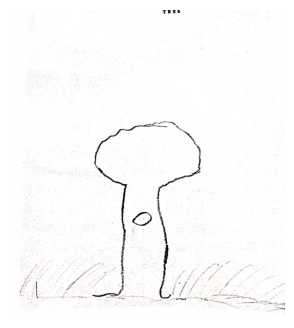

Raw Visual Features Detected: ['Cloud-Shaped Branches', 'Roots']

--- Psychological Interpretation ---
Based on the provided knowledge base, the detected features "Cloud-Shaped Branches" and "Roots" can be semantically matched to the following interpretations:

1. Cloud-Shaped Branches:
   - When branches are depicted as cloud-like, it can imply inhibitions that prevent outward discharge of aggression. The tree may represent an individual who has internalized their hostility and aggression, which is a common defense mechanism to avoid confrontation or conflict.
   - In some cases, cloud-shaped branches can also indicate a tendency towards intratensive ruminative tendencies, where the individual spends a lot of time thinking about past experiences and emotions.

2. Roots:
   - Roots are an essential part of a tree, representing the foundation and connection to the ground, symbolizing reality and the individual's grounding in their environment.
   - Depicted roots can provide insight int

In [ ]:
# --- 4. RUN THE FULL PIPELINE ON A TEST IMAGE ---

# TODO: Change this to the image you want to test
TEST_IMAGE_PATH = '/home/akmal-ali/3rd_year/cw/dsi/project/Dataset/test/test.png' # Example path
print(f"\n--- 1. Analyzing Image: {TEST_IMAGE_PATH} ---")
image = Image.open(TEST_IMAGE_PATH).convert("RGB")

# --- STAGE 1: The "Seer" makes its predictions ---
input_tensor = val_transform(image)
input_batch = input_tensor.unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model_for_inference(input_batch)
    probs = torch.sigmoid(outputs)
    preds = (probs > 0.5).cpu().numpy()[0] # Use a 0.5 threshold

# Get the list of raw labels
predicted_labels = []
for i, prediction in enumerate(preds):
    if prediction == 1:
        predicted_labels.append(LABEL_NAMES[i])

print(f"--- 2. 'Seer' Model Detected Raw Labels: {predicted_labels} ---")

if not predicted_labels:
    print("\n--- FINAL REPORT ---")
    print("The 'Seer' (EfficientNet) detected no specific features.")
else:
    # --- STAGE 2: The "Interpreter" writes the report ---

    # 2a. Create the prompt for the LLM
    system_prompt = (
        "You are an expert clinical psychologist specializing in the HTP (House-Tree-Person) "
        "projective test. Your task is to interpret a list of observed features from a tree drawing. "
        "You will be given a knowledge base of interpretations and a list of detected features. "
        "Your job is to semantically match the detected features to the *closest* concepts "
        "in your knowledge base and provide a concise, objective interpretation."
    )

    user_prompt = (
        f"Here is your knowledge base of interpretations:\n"
        f"--- KNOWLEDGE BASE ---\n{RAG_CONTEXT}\n--- END KNOWLEDGE BASE ---\n\n"
        f"A vision model has analyzed a tree drawing and detected the following raw visual features: {predicted_labels}\n\n"
        "Please provide a psychological interpretation by matching these features to the knowledge base. "
        "Be clinical and reference the concepts from the knowledge base in your analysis."
    )

    # Format the prompt using the Mistral chat template
    chat = [
        {"role": "user", "content": f"{system_prompt}\n\n{user_prompt}"}
    ]
    prompt_template = llm_tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)

    # 2c. Tokenize and generate the response
    inputs = llm_tokenizer(prompt_template, return_tensors="pt").to(device)

    print("--- 3. 'Interpreter' Model is Generating Analysis... ---")

    with torch.no_grad():
        output = llm_model.generate(**inputs, max_new_tokens=300, do_sample=False)

    response_text = llm_tokenizer.decode(output[0], skip_special_tokens=True)

    # Clean the output (it will include the prompt)
    final_analysis = response_text.split("[/INST]")[-1].strip()

    # 4. Print the Final, Generalized Report
    print("\n--- 📊 FINAL REPORT ---")
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    print(f"Raw Visual Features Detected: {predicted_labels}\n")
    print("--- Psychological Interpretation ---")
    print(final_analysis)